In [1]:
import pandas as pd
import numpy as np
import random
import datetime

from sklearn.preprocessing import RobustScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
import torch
import torch.utils.data as data_torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport # подробный разбор признаков

In [2]:
data_patch = '.\\'

In [3]:
pd.read_csv(data_patch + 'train.csv')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [4]:
def preprocessing_data(filename, test=False):
    
    dataframe = pd.read_csv(filename).copy()
    if test:
        dataframe['PassengerId'].to_csv('sample_submission_NET.csv', sep=',', index=False)
    else:
        dataframe['Transported'] = dataframe['Transported'].map({True:1,False:0})
        transported = dataframe['Transported']
        dataframe = dataframe.drop(['Transported'], axis=1)
                    
    mask = dataframe['Age'].isna()
    dataframe.loc[mask, 'Age'] = np.random.randint(10, 50, mask.sum())
    dataframe['Cabin'] = dataframe['Cabin'].fillna(dataframe['Cabin'].mode()[0])
    dataframe['PassengerId'] = dataframe['PassengerId'].apply(lambda x: str(x).split('_')[0])
    dataframe['Name'] = dataframe['Name'].fillna(dataframe['Name'].mode()[0])
    dataframe['Surname'] = dataframe['Name'].apply(lambda x: str(x).split(' ')[1])
                
    for i, col in enumerate(['Cabin_deck', 'Cabin_num', 'Cabin_side']):
        dataframe[col] = dataframe['Cabin'].apply(lambda x: str(x).split('/')[i])
    
    for col in ['PassengerId', 'Cabin_deck', 'Cabin_side', 'Surname', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP']:
        for i, x in enumerate(list(dataframe[col].value_counts(ascending = True).index[:])):
            dataframe[col] = dataframe[col].replace(x, (i+1))
        
    # for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    #     dataframe[col] = dataframe[col].apply(lambda x: 1 if x!=0 else 0)
    
    dataframe = dataframe.drop(['Cabin', 'Cabin_num', 'Name'], axis=1)
    
    for col in dataframe.columns:
        modde = dataframe[col].mode()[0]
        dataframe[col] = dataframe[col].fillna(modde)
        a = dataframe[col].unique()
        if col in ['HomePlanet', 'Destination']:
            b = [1, 2, 3]
            dataframe[col] = dataframe[col].replace(list(set(a).symmetric_difference(b)), modde)
        elif col in ['CryoSleep', 'VIP']:
            b = [1, 0]
            dataframe[col] = dataframe[col].replace(list(set(a).symmetric_difference(b)), modde)
                       
    data_scaled = RobustScaler().fit_transform(dataframe)
    data_scaled = MinMaxScaler().fit_transform(data_scaled)
    data_scaled = pd.DataFrame(data=data_scaled)
      
    if test:        
        data_scaled.to_csv('test_data.csv', sep=',', index=False)
    else:
        X_train, X_val, y_train, y_val = train_test_split(data_scaled, transported, test_size=0.2, random_state=2, stratify=transported, shuffle=True)
        
        X_train['Transported'] = y_train
        X_val['Transported'] = y_val
        X_train.to_csv('train_data.csv', sep=',', index=False)
        X_val.to_csv('val_data.csv', sep=',', index=False)

In [5]:
preprocessing_data(data_patch + 'train.csv')
preprocessing_data(data_patch + 'test.csv', test=True)

In [6]:
class TitanicDataset(data_torch.Dataset):
    
    def __init__(self, filename, Train=True):
        self.dataframe = pd.read_csv(filename).copy()
                      
        self.Train = Train
        
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, idx):
        if(self.Train):
            survived = self.dataframe['Transported']
            survived = np.array(survived)[idx]
            features = self.dataframe.drop(['Transported'], axis=1)
            features = np.array(features)[idx]
        else:
            features = np.array(self.dataframe)[idx]
                
        if(self.Train):
            return features, survived
        else:
            return features

In [7]:
train_dataset = TitanicDataset(data_patch + 'train_data.csv')
val_dataset = TitanicDataset(data_patch + 'val_data.csv')
testing_dataset = TitanicDataset(data_patch + 'test_data.csv', Train=False)

In [8]:
train_dataset.__getitem__(5)

(array([6.08108108e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        4.68354430e-01, 1.00000000e+00, 1.95435192e-03, 8.38560360e-04,
        1.10675975e-03, 3.59692967e-02, 1.24311109e-04, 9.25992780e-01,
        8.57142857e-01, 0.00000000e+00]),
 0)

In [9]:
train_dataload = data_torch.DataLoader(train_dataset, shuffle=True, batch_size=100)
t = iter(train_dataload)
print(next(t))

[tensor([[0.5857, 0.0000, 1.0000,  ..., 0.4034, 0.2857, 0.0000],
        [0.9641, 0.5000, 1.0000,  ..., 0.6471, 0.4286, 1.0000],
        [0.6744, 0.0000, 0.0000,  ..., 0.6489, 0.7143, 0.0000],
        ...,
        [0.5796, 1.0000, 1.0000,  ..., 0.9003, 1.0000, 0.0000],
        [0.7124, 0.5000, 1.0000,  ..., 0.5230, 0.4286, 0.0000],
        [0.8020, 1.0000, 1.0000,  ..., 0.9851, 0.7143, 1.0000]],
       dtype=torch.float64), tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1])]


In [10]:
val_dataload = data_torch.DataLoader(val_dataset, shuffle=True, batch_size=100)
t = iter(val_dataload)
print(next(t))

[tensor([[0.3851, 0.0000, 1.0000,  ..., 0.4084, 1.0000, 1.0000],
        [0.8486, 0.5000, 1.0000,  ..., 0.8700, 0.5714, 1.0000],
        [0.5209, 0.5000, 0.0000,  ..., 0.6561, 0.5714, 0.0000],
        ...,
        [0.9749, 1.0000, 1.0000,  ..., 0.9986, 0.8571, 1.0000],
        [0.8250, 1.0000, 1.0000,  ..., 0.9743, 1.0000, 0.0000],
        [0.9646, 0.0000, 1.0000,  ..., 0.9698, 1.0000, 0.0000]],
       dtype=torch.float64), tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 1])]


In [11]:
test_dataload = data_torch.DataLoader(testing_dataset, shuffle=True, batch_size=100)
t = iter(test_dataload)
print(next(t))

tensor([[0.1904, 1.0000, 1.0000,  ..., 0.0684, 1.0000, 1.0000],
        [0.9151, 0.5000, 1.0000,  ..., 0.9994, 0.4286, 1.0000],
        [0.2982, 1.0000, 1.0000,  ..., 0.9391, 1.0000, 0.0000],
        ...,
        [0.3671, 1.0000, 0.0000,  ..., 0.2912, 0.8571, 0.0000],
        [0.9200, 1.0000, 0.0000,  ..., 0.8765, 0.8571, 0.0000],
        [0.0088, 1.0000, 0.0000,  ..., 0.6497, 0.8571, 0.0000]],
       dtype=torch.float64)


In [15]:
class Net(nn.Module):
    def __init__(self, col, a, b, c, d):
        super(Net, self).__init__()
        self.b1 = nn.Sequential(
            nn.Linear(in_features=col,out_features=a),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(a),
            nn.Linear(in_features=a,out_features=b),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(b),
            nn.Linear(in_features=b,out_features=c),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(c),
            nn.Linear(in_features=c,out_features=d),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(d),
            nn.Linear(in_features=d,out_features=1),
            nn.Sigmoid()
        )
    def forward(self,x):
        x = self.b1(x)
        return x

class Net(nn.Module):
    def __init__(self, col, a, b):
        super(Net, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(col, a),
            nn.BatchNorm1d(a),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(a, b),
            nn.BatchNorm1d(b),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(b, a),
            nn.BatchNorm1d(a),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(a, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class Net(nn.Module):
    def __init__(self, col, a, b, c, d):
        super(Net, self).__init__()
        self.b1 = nn.Sequential(
            nn.Linear(in_features=col,out_features=a),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(a),
            nn.Linear(in_features=a,out_features=b),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(b),
            nn.Linear(in_features=b,out_features=c),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(c),
            nn.Linear(in_features=c,out_features=d),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(d),
            nn.Linear(in_features=d,out_features=int(d/2)),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(int(d/2)),
            nn.Linear(in_features=int(d/2),out_features=c),
            nn.ReLU(),
            nn.BatchNorm1d(c),
            nn.Linear(in_features=c,out_features=1),
            nn.Sigmoid()
        )
    def forward(self,x):
        x = self.b1(x)
        return x

In [16]:
size_columns = len(next(iter(train_dataload))[0][0])
hidden_layer1_coeff = 10
hidden_layer2_coeff = 12
hidden_layer3_coeff = 8
hidden_layer4_coeff = 5
lr = 0.05
momentum = 0.9
epochs = 50
hidden_layer1 = round(hidden_layer1_coeff * size_columns)
hidden_layer2 = round(hidden_layer2_coeff * size_columns)
hidden_layer3 = round(hidden_layer3_coeff * size_columns)
hidden_layer4 = round(hidden_layer4_coeff * size_columns)

In [17]:
#net = Net(size_columns, hidden_layer1, hidden_layer2)
net = Net(size_columns, hidden_layer1, hidden_layer2, hidden_layer3, hidden_layer4)
print(net)


Net(
  (b1): Sequential(
    (0): Linear(in_features=14, out_features=140, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): BatchNorm1d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=140, out_features=168, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): BatchNorm1d(168, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=168, out_features=112, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.4, inplace=False)
    (11): BatchNorm1d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=112, out_features=70, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.4, inplace=False)
    (15): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Linear(in_features=70, out_features=1, bias=True)
    (17): Sigmoid()
  )
)


net = Net(size_columns, hidden_layer1, hidden_layer2)
print(net)

In [18]:
#optimizer = optim.SGD(net.parameters(), lr = lr, momentum = momentum)
optimizer = optim.Adam(net.parameters(), lr = lr)
criterion = nn.BCELoss()

In [19]:
def train(model, training_data, optimizer, criterion, epochs=10):
    #dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dev = torch.device("cpu")
    model = model.to(dev)
    losses = []
    accuracy = []
    for epoch in range(epochs):
        running_loss = 0.0
        batch = 0
        for  X, y in training_data:
            X , y = X.to(dev) , y.to(dev)
            
            features = len(next(iter(training_data))[0][0])
            X = X.view(-1, features)
            y = y.view(-1, 1)
            
            optimizer.zero_grad()
            
            prob_y = model(X.float())
            
            y_pred = (prob_y > torch.Tensor([0.5])).long().squeeze()
            
            accuracy.append((y_pred==y).sum().item()/len(y_pred))
            
            loss = criterion(prob_y, y.float())
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            
            batch += 1
        # средние потери на каждой эпохе    
        losses.append(running_loss/batch)
        if epoch%5==0:
            print('epochs {} done'.format(epoch+5))
        
    print("Fin")
    return (losses, accuracy)

In [20]:
losses, accuracy = train(net, train_dataload, optimizer, criterion)

epochs 5 done
epochs 10 done
Fin


In [21]:
def plot_loss_acc(losses, accuracy):
    figure = plt.figure(figsize=(9,3))
    plt.subplot(121, title="losses")
    plt.plot(range(1, len(losses)+1), losses)
    plt.xlabel("epoch №")
    plt.ylabel("loss")
    plt.subplot(122, title="accuracy")
    plt.plot(range(1, len(accuracy)+1), accuracy)
    plt.xlabel("batch №")
    plt.ylabel("accuracy")

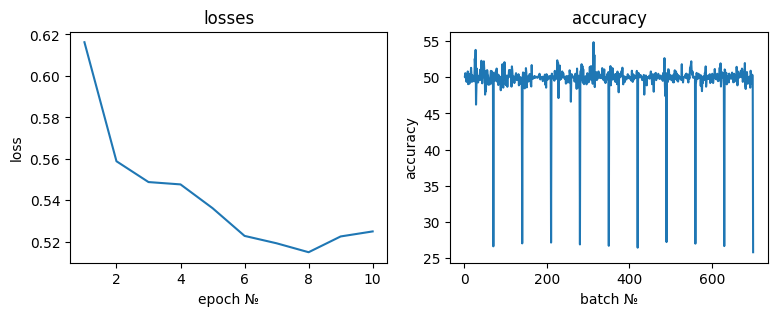

In [22]:
plot_loss_acc(losses, accuracy)

In [23]:
MODEL_PATH = '.\\titanic_net_1.pth'
torch.save(net.state_dict(), MODEL_PATH)

In [24]:
def calc_test_acc(model, data, test=False):
    correct = 0
    total = 0
    y_pred_test=[]
    with torch.no_grad():
        
        if test==False:
            for X, y in data:
                X = X.squeeze()
                prob_y = model(X.float())                     
                y = y.squeeze()
                y_pred = (prob_y > torch.Tensor([0.5])).long().squeeze()
                total += len(y_pred)
                correct += (y_pred == y).sum().item()
            print(round((correct/total)*100, 3))
        else:
            for X in data:
                X = X.squeeze()
                prob_y = model(X.float())
                y_pred = (prob_y > torch.Tensor([0.5])).long().squeeze().numpy()
                y_pred_test = np.concatenate((y_pred_test, y_pred), axis=None)                        
            data = pd.read_csv('sample_submission_NET.csv', sep=',')
            data['Transported'] = y_pred_test
            data['Transported'] = data['Transported'].astype(bool)
            data.to_csv('sample_submission_NET.csv', sep=',', index=False)

In [25]:
calc_test_acc(net, train_dataload)

74.633


In [26]:
calc_test_acc(net, val_dataload)

74.238


In [27]:
calc_test_acc(net, test_dataload, test=True)

In [28]:
pd.read_csv('sample_submission_NET.csv', sep=',').copy()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False
